# Assignment 2

## Import Packages and Read in Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from yellowbrick.features import PCA as YBPCA
import scipy.spatial

C:\Users\xrzha\miniconda3\envs\DSA3101\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
dataset = pd.read_csv("DSA3101_Hackathon_Data.csv")

In [4]:
dataset = dataset.rename(columns={"Panel ID": "ID"})

In [5]:
dataset.head()

,ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [6]:
cat = pd.read_csv("DSA3101_Hackathon_Categories_Information.csv")

In [7]:
cat.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [8]:
panel = pd.read_excel("DSA3101_Hackathon_Panelists_Demographics.xlsx")

In [9]:
panel.head()

,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North


In [10]:
overall = pd.merge(pd.merge(dataset,cat),panel)

In [11]:
overall.head()

,ID,Date,Category,Pack Size,Volume,Spend,Calories/100g,Price per Volume,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101011101,2018-06-03,CSD,48,72.0,75.8,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
2,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
3,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
4,Panel 101011101,2020-05-17,CSD,2,3.5,6.2,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North


In [12]:
# only keep ethnicity---chinese, malay, others
overall["ethnicity"] = overall["Ethnicity"].str.split().str[-1]
overall["#HH"] = overall["#HH"].str.split().str[0]
overall.head()

,ID,Date,Category,Pack Size,Volume,Spend,Calories/100g,Price per Volume,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,ethnicity
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay
1,Panel 101011101,2018-06-03,CSD,48,72.0,75.8,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay
2,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay
3,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay
4,Panel 101011101,2020-05-17,CSD,2,3.5,6.2,44,2.2,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay


In [13]:
#plt.figure(figsize=(10,7))
#plt.title("Histogram of Spends")
#plt.hist(overall_group_by_cat.Spend, bins = 100)
#plt.xlabel("Spend")
#plt.ylabel("Count")
#plt.show()

## K-Means Clustering

In [105]:
# Add a column reflecting spending,frequency,and recency using k-means
k_means_data = dataset.drop(columns=['Pack Size', 'Volume'])
k_means_data["Date"] = pd.to_datetime(k_means_data['Date'],format='%Y-%m-%d')
refDate = pd.to_datetime('20200615', format='%Y%m%d') #Creating the baseline date (2015-04-01)
k_means_data['Date1']=k_means_data['Date']
k_means_data = k_means_data.groupby(['ID']).agg({'Spend': lambda x: sum(x),
                                                        'Date': lambda x: len(x.unique()),
                                                        'Date1': lambda x: (refDate-x.max()).days}).reset_index()

k_means_data.rename(columns={'Date' : 'Visiting_Times','Date1' : 'Recent_Visit', 'Pack Size' : 'Total_Packs', 'Volume':'Total_Volume', 'Spend':'Monetary'},inplace=True)
k_means_data.head()

,ID,Monetary,Visiting_Times,Recent_Visit
0,Panel 101011101,3902.2,109,15
1,Panel 101016101,1888.2,71,8
2,Panel 101019101,7333.3,153,1
3,Panel 101024101,5990.7,153,1
4,Panel 105009103,4749.1,156,1


In [106]:
customers = k_means_data['ID']      #for recovering customers after k_means clustering
k_means_data.drop(columns = ['ID'], inplace = True)

In [87]:
k_means_data.drop(columns = ['Recent_Visit'], inplace = True)

In [107]:
dataarray = k_means_data.to_numpy()
dataarray

array([[3.9022e+03, 1.0900e+02, 1.5000e+01],
       [1.8882e+03, 7.1000e+01, 8.0000e+00],
       [7.3333e+03, 1.5300e+02, 1.0000e+00],
       ...,
       [4.0000e+02, 3.0000e+00, 1.6900e+02],
       [2.8950e+02, 1.5000e+01, 1.0000e+00],
       [2.6430e+02, 7.0000e+00, 1.1300e+02]])

In [119]:
from sklearn.cluster import KMeans
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

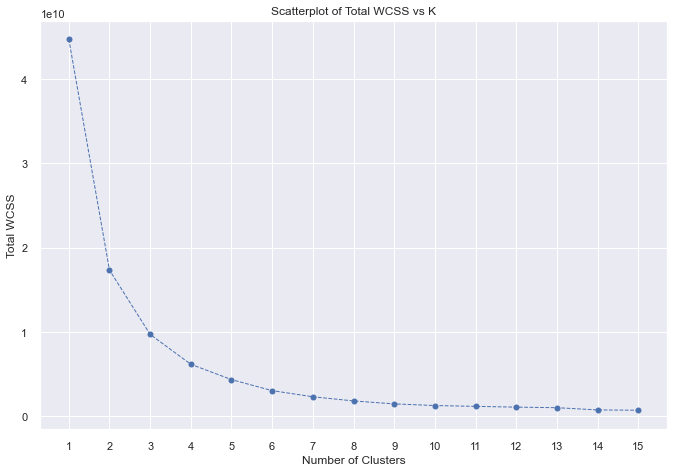

In [120]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [121]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

#To locate the elbow point of the curve using kneed package

4

In [123]:
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
# A list holds the silhouette coefficients for each k

silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

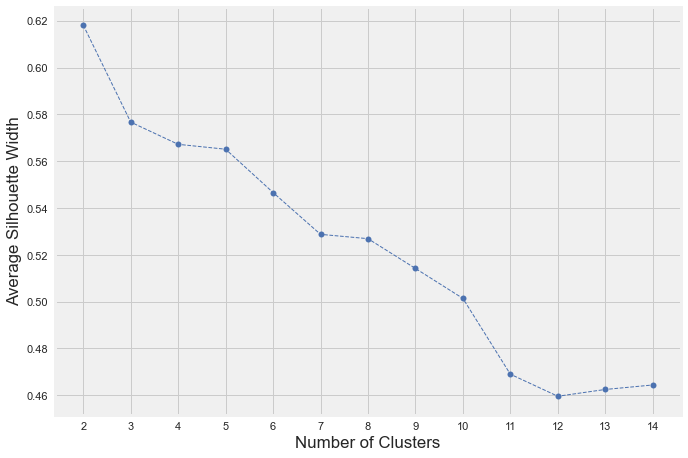

In [124]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [109]:
# Use silhoutte coefficient to test using scaled_features or not
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

In [126]:
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

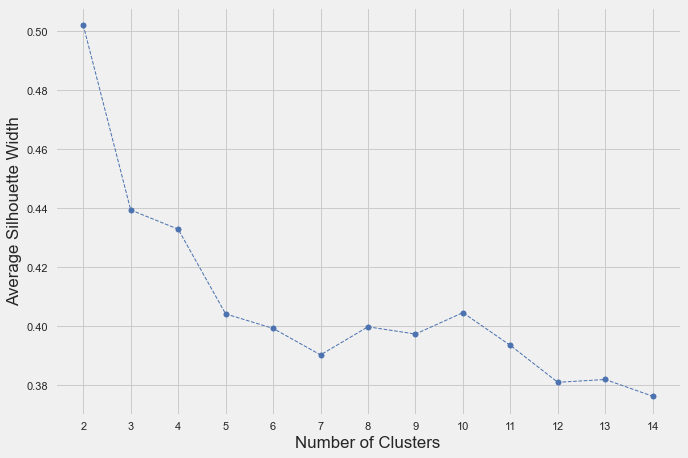

In [127]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

## Not using scaled features because silhouette coefficient is not good

In [128]:
# We Choose KMeans with 2 clusters because it has best silhouette score
kmeans2 = KMeans(init="random",n_clusters =2 , n_init = 10, max_iter = 300, random_state = 42)
kmeans2.fit(dataarray)
clustergroups2 = kmeans2.labels_ #The cluster number for each row

In [129]:
Clustercenters2 = pd.DataFrame(kmeans2.cluster_centers_) #Dataframe of cluster centers
Clustercenters2.rename(columns={0: "Spend", 1: "Visiting_Times" , 2:"Rencent_Days"},inplace=True)
Clustercenters2.index.name = "Clusters"

In [130]:
Clustercenters2

# cluster 1: high spenders, high frequency and very recent visit
# cluster 0: low spenders, low frequency and long ago

,Spend,Visiting_Times,Rencent_Days
Clusters,,,
0,8862.782156,126.194012,18.235928
1,2220.864182,58.770512,295.690962


In [131]:
from decimal import Decimal

print(kmeans2.inertia_)
print('%.1E' % Decimal(kmeans2.inertia_))
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

17329891036.553177
1.7E+10


In [132]:
model_2 = k_means_data.copy()
model_2['ID'] = customers
model_2['Clusters'] = pd.DataFrame(clustergroups2) #Combining the column of clusters to the original dataframe

In [140]:
model_2['Clusters'] = model_2['Clusters'].replace({1: 'normal', 0: 'loyal'})
model_2

,Monetary,Visiting_Times,Recent_Visit,ID,Clusters
0,3902.2,109,15,Panel 101011101,normal
1,1888.2,71,8,Panel 101016101,normal
2,7333.3,153,1,Panel 101019101,loyal
3,5990.7,153,1,Panel 101024101,loyal
4,4749.1,156,1,Panel 105009103,normal
...,...,...,...,...,...
3231,216.9,10,29,Panel 801900701,normal
3232,1165.0,22,1,Panel 801901201,normal
3233,400.0,3,169,Panel 801903201,normal
3234,289.5,15,1,Panel 801903801,normal


In [141]:
pd.DataFrame(model_2.groupby('Clusters').Monetary.count())

,Monetary
Clusters,
loyal,838
normal,2398


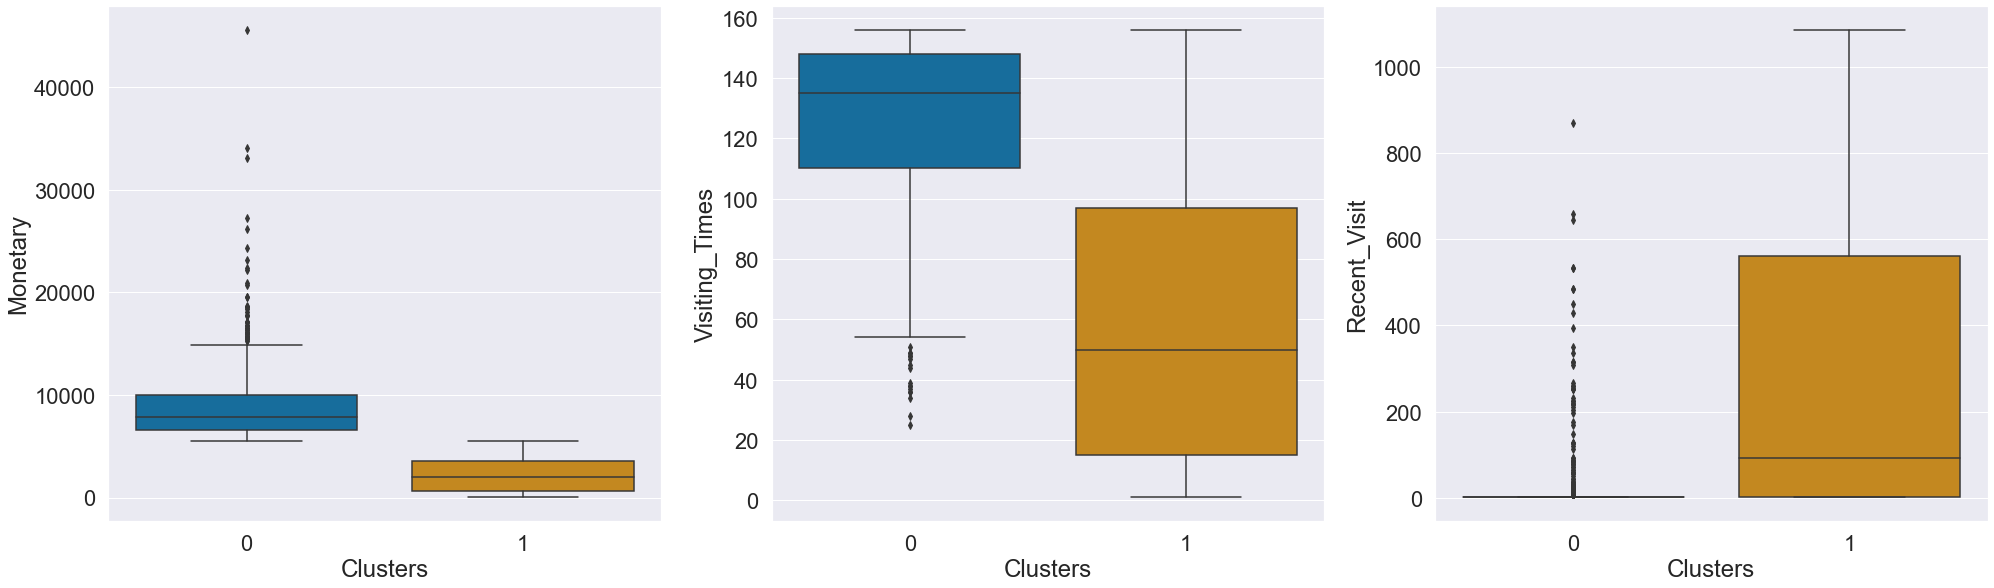

In [139]:
#Boxplot for each cluster and feature
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(len(model_2.columns)-2):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=model_2.columns[i], x=model_2.Clusters, data=model_2, palette="colorblind")

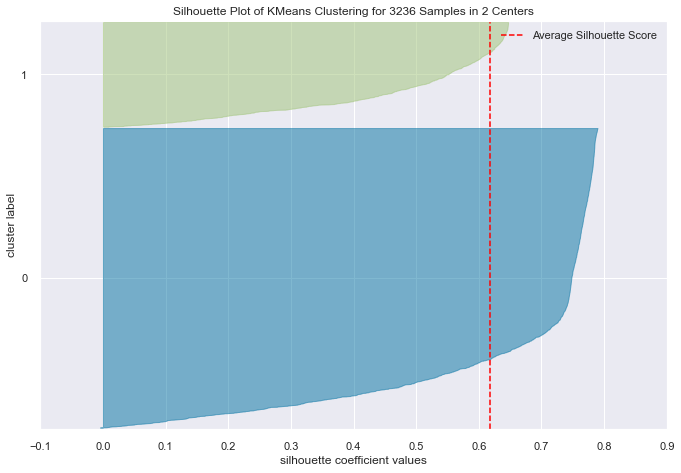

For n_clusters = 2 The average silhouette_score is: 0.6181081508303704


In [138]:
from yellowbrick.cluster import silhouette_visualizer
model = KMeans(2, random_state=42)
plt.figure(figsize=(10, 7)) 
sns.set(font_scale = 1)
silhouette_visualizer(model, dataarray, colors='yellowbrick')
print("For n_clusters = 2 The average silhouette_score is: " + str(silhouette_score(dataarray, model.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 2

## Cluster Customers based on demographics and k-means result

In [143]:
# Add K_means cluster result to overall dataframe
overall = pd.merge(overall, model_2[['ID','Clusters']])

In [144]:
overall

,ID,Date,Category,Pack Size,Volume,Spend,Calories/100g,Price per Volume,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,ethnicity,Clusters
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5,44,2.20,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay,normal
1,Panel 101011101,2018-06-03,CSD,48,72.0,75.8,44,2.20,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay,normal
2,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.20,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay,normal
3,Panel 101011101,2020-04-19,CSD,1,1.5,2.7,44,2.20,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay,normal
4,Panel 101011101,2020-05-17,CSD,2,3.5,6.2,44,2.20,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3,North,Malay,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318019,Panel 801697401,2019-08-04,Kaya,1,0.2,4.6,310,14.21,Healthy,Income 3000 - 3999,South Chinese,Nesting Families,Urban,5,South,Chinese,normal
1318020,Panel 801697401,2019-08-04,Milk Powder-Kids,2,1.8,41.8,62,34.03,Healthy,Income 3000 - 3999,South Chinese,Nesting Families,Urban,5,South,Chinese,normal
1318021,Panel 801733501,2019-09-29,Eggs,1,10.0,7.0,97,0.37,Healthy,Income >5000,Central Chinese,Matured Families,Urban,1-3,Central,Chinese,normal
1318022,Panel 801733501,2019-10-06,Eggs,1,10.0,7.0,97,0.37,Healthy,Income >5000,Central Chinese,Matured Families,Urban,1-3,Central,Chinese,normal


In [145]:
# there are three ways of grouping. We think the 2nd and 3rd are preferred as the corr matrix of 1st method has fewer values >0.7.
overall_group_by_cat = overall.groupby(['ID','Category'])['Spend'].sum().to_frame()
print("Min Spend: " , overall_group_by_cat.Spend.min())
print("Max Spend: " , overall_group_by_cat.Spend.max())

Min Spend:  0.0
Max Spend:  19544.000000000004


In [146]:
#overall_group_by_cat2 = overall.groupby(['Income','Strata','location','#HH','ethnicity', 'Category'])['Spend'].sum()
overall_group_by_cat3 = overall.groupby(['Income','Strata','location','#HH','ethnicity','BMI','Clusters', 'Category'])['Spend'].sum()

In [147]:
overall_group_by_cat3

Income              Strata  location  #HH  ethnicity  BMI           Clusters  Category        
Income 1500 - 1999  Rural   Central   1-3  Chinese    Healthy       normal    Beer                13.5
                                                                              Biscuits            10.2
                                                                              CSD                  5.7
                                                                              Canned Product      24.6
                                                                              Coffee              34.4
                                                                                                  ... 
Income >5000        Urban   South     7+   Others     Under Weight  normal    Seasoning Powder    32.2
                                                                              Snack                8.5
                                                                              Sug

In [148]:
overall_group_by_cat3.to_frame().reset_index().columns

Index(['Income', 'Strata', 'location', '#HH', 'ethnicity', 'BMI', 'Clusters',
       'Category', 'Spend'],
      dtype='object')

In [149]:
#df = overall_group_by_cat.reset_index().pivot(index='ID', columns='Category', values='Spend').fillna(0)
#df2 = overall_group_by_cat2.unstack(['Category']).fillna(0)
df3 = overall_group_by_cat3.unstack(['Category'])
df3

Category                                                                Baby Cereal  \
Income             Strata location #HH ethnicity BMI          Clusters                
Income 1500 - 1999 Rural  Central  1-3 Chinese   Healthy      normal            NaN   
                                       Malay     Healthy      loyal             NaN   
                                                 Over Weight  normal            NaN   
                                   4   Malay     Over Weight  normal            NaN   
                                                 Under Weight loyal             NaN   
...                                                                             ...   
Income >5000       Urban  South    7+  Chinese   Under Weight normal            NaN   
                                       Malay     Over Weight  normal            NaN   
                                                 Under Weight normal            NaN   
                                       Others    Healthy      normal            NaN   
                                                 Under Weight normal            NaN   

Category                                                                Beer  \
Income             Strata location #HH ethnicity BMI          Clusters         
Income 1500 - 1999 Rural  Central  1-3 Chinese   Healthy      normal    13.5   
                                       Malay     Healthy      loyal      NaN   
                                                 Over Weight  normal     NaN   
                                   4   Malay     Over Weight  normal     NaN   
                                                 Under Weight loyal      NaN   
...                                                                      ...   
Income >5000       Urban  South    7+  Chinese   Under Weight normal     NaN   
                                       Malay     Over Weight  normal     NaN   
                                                 Under Weight normal     NaN   
                                       Others    Healthy      normal     NaN   
                                                 Under Weight normal     NaN   

Category                                                                Belacan  \
Income             Strata location #HH ethnicity BMI          Clusters            
Income 1500 - 1999 Rural  Central  1-3 Chinese   Healthy      normal        NaN   
                                       Malay     Healthy      loyal        15.2   
                                                 Over Weight  normal        NaN   
                                   4   Malay     Over Weight  normal        NaN   
                                                 Under Weight loyal         NaN   
...                                                                         ...   
Income >5000       Urban  South    7+  Chinese   Under Weight normal        NaN   
                                       Malay     Over Weight  normal       37.4   
                                                 Under Weight normal        1.0   
                                       Others    Healthy      normal        NaN   
                                                 Under Weight normal        NaN   

Category                                                                Bird Nest  \
Income             Strata location #HH ethnicity BMI          Clusters              
Income 1500 - 1999 Rural  Central  1-3 Chinese   Healthy      normal          NaN   
                                       Malay     Healthy      loyal           NaN   
                                                 Over Weight  normal          NaN   
                                   4   Malay     Over Weight  normal          NaN   
                                                 Under Weight loyal           NaN   
...                                                                           ...   
Income >5000       Urban  South    7+  Chinese   Under Weight norma

In [150]:
new = df3.rename_axis(None, axis=1).reset_index()
new['Customer'] = np.arange(len(new))
ref_tab = new[['Customer','Income', 'Strata', 'location', '#HH', 'ethnicity','BMI','Clusters']]
rating_matrix = new.set_index('Customer').drop(columns = ['Income', 'Strata', 'location', '#HH', 'ethnicity','BMI','Clusters'])

for col in rating_matrix.columns:
    rating_matrix[col] = pd.qcut(x=rating_matrix[col], q = 10,labels=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]).astype('float64')
rating_matrix = rating_matrix.fillna(0)
rating_matrix


,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,...,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Customer,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,1.0,0.0,1.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
1,0.0,0.0,3.5,0.0,2.5,5.0,0.0,2.0,0.0,4.0,...,2.0,2.5,0.0,0.0,5.0,4.0,2.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.5,2.0,1.0,0.0,0.0,1.5,...,3.5,3.0,1.5,0.0,2.0,3.0,3.0,0.0,3.5,2.0
4,0.0,0.0,0.0,0.0,1.5,2.5,0.0,0.5,1.5,1.0,...,0.5,0.0,3.5,0.0,1.0,2.0,1.5,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1552,0.0,0.0,4.5,0.0,4.0,3.0,3.0,0.5,0.5,4.5,...,4.5,3.5,3.0,0.0,3.0,3.5,3.5,0.0,2.5,0.5
1553,0.0,0.0,0.5,0.0,0.5,1.5,0.0,0.0,1.0,0.0,...,0.5,0.0,0.0,0.0,0.5,1.5,0.0,0.0,0.0,0.0


In [151]:
# the ref_tab is used for checking the demographics of certain customer group
print(ref_tab.Customer.nunique())
ref_tab

1556


,Customer,Income,Strata,location,#HH,ethnicity,BMI,Clusters
0,0,Income 1500 - 1999,Rural,Central,1-3,Chinese,Healthy,normal
1,1,Income 1500 - 1999,Rural,Central,1-3,Malay,Healthy,loyal
2,2,Income 1500 - 1999,Rural,Central,1-3,Malay,Over Weight,normal
3,3,Income 1500 - 1999,Rural,Central,4,Malay,Over Weight,normal
4,4,Income 1500 - 1999,Rural,Central,4,Malay,Under Weight,loyal
...,...,...,...,...,...,...,...,...
1551,1551,Income >5000,Urban,South,7+,Chinese,Under Weight,normal
1552,1552,Income >5000,Urban,South,7+,Malay,Over Weight,normal
1553,1553,Income >5000,Urban,South,7+,Malay,Under Weight,normal
1554,1554,Income >5000,Urban,South,7+,Others,Healthy,normal


In [152]:
finaldf = rating_matrix.reset_index().melt(id_vars=['Customer'], var_name='Category', value_name='Spend')
finaldf = finaldf[finaldf.Spend != 0]
finaldf

,Customer,Category,Spend
38,38,Baby Cereal,3.5
53,53,Baby Cereal,1.5
81,81,Baby Cereal,3.0
82,82,Baby Cereal,2.0
85,85,Baby Cereal,2.5
...,...,...,...
96463,1547,Yoghurts,5.0
96464,1548,Yoghurts,2.5
96465,1549,Yoghurts,2.5
96466,1550,Yoghurts,3.5


In [153]:
k = round(np.sqrt(62),0)#rating_matrix
k

8.0

In [154]:
def recommend(customerid, k):
    customervec = rating_matrix.loc[customerid,:].to_numpy()
    indexofcustomer = rating_matrix.index.get_loc(customerid)
    
    cosinelist = []
    # Getting the list of cosine similarities
    for i in range(0,len(rating_matrix)):
        v = rating_matrix.iloc[i,:].to_numpy()
        cosdist = scipy.spatial.distance.cosine(customervec,v)
        cosinelist.append(cosdist)
    
    sort_index = np.argsort(cosinelist).tolist()
    sort_index.pop(indexofcustomer)
    # We will exclude the customer himself in the kNN algorithm when taking average
    #k = 8
    # We’ve arbitrarily decided to find the 20 most similar customers
    # Industry rule of thumb: sqrt(n) , domain knowledge, odd number
    neighbors=[]
    for j in range(0,k):
        v = rating_matrix.iloc[sort_index[j],:].to_numpy()
        v[v == 0] = 'nan'
        neighbors.append(v)
    averagerating = np.nanmean(neighbors, axis=0)
    # Average rating of top k neighbors for each product, ignoring NaNs
    
    top_products = np.argsort(averagerating).tolist()
    top_products.reverse()
    # argsort sorts in ascending order, we want top ratings to be at the front. Hence we reverse the order
    check_matrix = finaldf.pivot_table(index='Customer', columns='Category', values='Spend')
    topproductslist = []
    i = 0
    # We want to recommend the top n products that a customer has not rated before
    while i < 10:
        for m in top_products:
            if np.isnan(check_matrix.loc[customerid,check_matrix.columns[m]]) :
                topproductslist.append(m)
                i += 1
    if len(topproductslist) >=10:
        topproductslist = topproductslist[:10]
    else:
        topproductslist = topproductslist[:len(topproductslist)]
    reclist = []
    for i in range(0,len(topproductslist)):
        reclist.append(rating_matrix.columns[topproductslist[i]]) 
    return reclist

In [155]:
ref_tab[ref_tab.Customer == 15]

,Customer,Income,Strata,location,#HH,ethnicity,BMI,Clusters
15,15,Income 1500 - 1999,Rural,East Coast,1-3,Others,Healthy,normal


In [156]:
print("\nRecommendation for Customer 15")
print(str(recommend(15,8))+"\n")



Recommendation for Customer 15
['Baby Cereal', 'Wine', 'Energy Drinks', 'Milk Powder-Infant', 'RTD Coffee', 'Bird Nest', 'Cheese', 'Chocolate', 'Beer', 'CSD']



<ipython-input-154-2a49364eb7f2>:23: RuntimeWarning: Mean of empty slice
  averagerating = np.nanmean(neighbors, axis=0)


# Surprise

In [157]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNWithMeans, KNNBasic
from surprise import accuracy
np.random.seed(3101)

In [158]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(finaldf[['Customer', 'Category', 'Spend']], reader)

In [159]:
trainset = data.build_full_trainset()

In [169]:
print('Number of customer groups: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of customer groups:  1556 

Number of items:  62


In [161]:
np.random.seed(3101)
my_k = 30 #kNN: Number of K
my_min_k = 5
my_sim_options = {'name': 'cosine','user_based': True}  # compute similarities between users

algo = KNNWithMeans(k = my_k, min_k = my_min_k, sim_options = my_sim_options,verbose =True)

algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [162]:
np.random.seed(3101)
results = cross_validate(
    algo = algo, data = data,
    measures=['MAE'], cv=5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [163]:
print(results['test_mae'].mean())

0.9045432008288049


In [164]:
iid = finaldf['Category'].unique() #List of unique products
iids15 = finaldf.loc[finaldf['Customer']==15,'Category'] # List of products that customer cluster 15 has purchased
iid_to_pred = np.setdiff1d(iid,iids15) #The list of products customer cluster 15 has not purchased before


In [165]:
testset = [[15,iid,0] for iid in iid_to_pred]

In [166]:
predictions = algo.test(testset) # We now apply our model for customer 15 on all products not purchased 
pred_ratings = np.array([pred.est for pred in predictions])

In [167]:
pred_rating_sort = np.argsort(pred_ratings).tolist()
pred_rating_sort.reverse()
recommended10 = [iid_to_pred[x] for x in pred_rating_sort[:10]]

In [168]:
pred_ratings_top10 = [pred_ratings[x] for x in pred_rating_sort[:10]]

In [170]:
print("Recommendation for Customer Group 15 with Surprise :" , recommended10)

Recommendation for Customer Group 15 with Surprise : ['Fruit/Veg Juices', 'Chocolate', 'Cereal Beverage', 'CSD', 'Yoghurt Drink', 'Milk Powder-Infant', 'Isotonic Drinks', 'Tea', 'Snack', 'Soy Milk']


In [174]:
np.random.seed(3101)
MAElist = []
for i in range(1,21):
    my_test_k = i #kNN: Number of K
    my_min_test_k = i
    my_test_sim_options = {'name': 'cosine','user_based': True}  # compute similarities between customers
    algotest = KNNWithMeans(k = my_test_k, min_k = my_min_test_k, sim_options = my_test_sim_options,verbose = False)
    algotest.fit(trainset)
    results = cross_validate(algo = algotest, data = data,measures=['MAE'], cv=5)
    MAElist.append(results['test_mae'].mean())

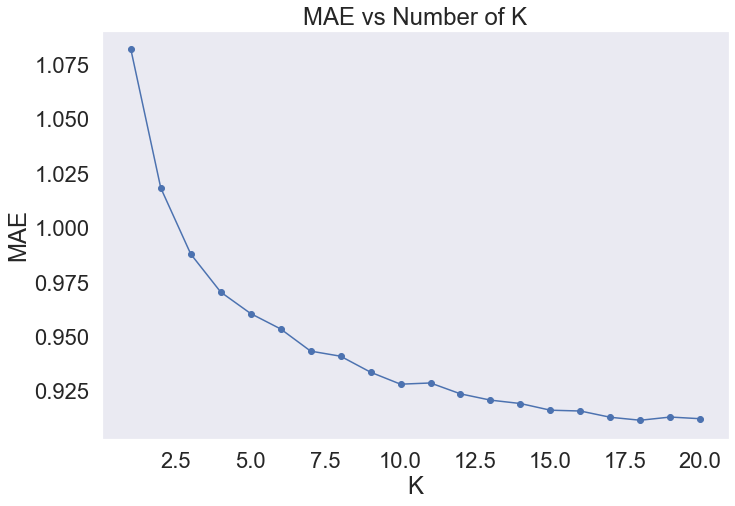

In [175]:
x = list(range(1,21))
plt.figure(figsize=(10,7))
plt.scatter(x,MAElist)
plt.plot(x,MAElist)
plt.title('MAE vs Number of K')
plt.xlabel('K')
plt.ylabel('MAE')
plt.grid()
plt.show()

## PCA Clustering

NameError: name 'corr' is not defined

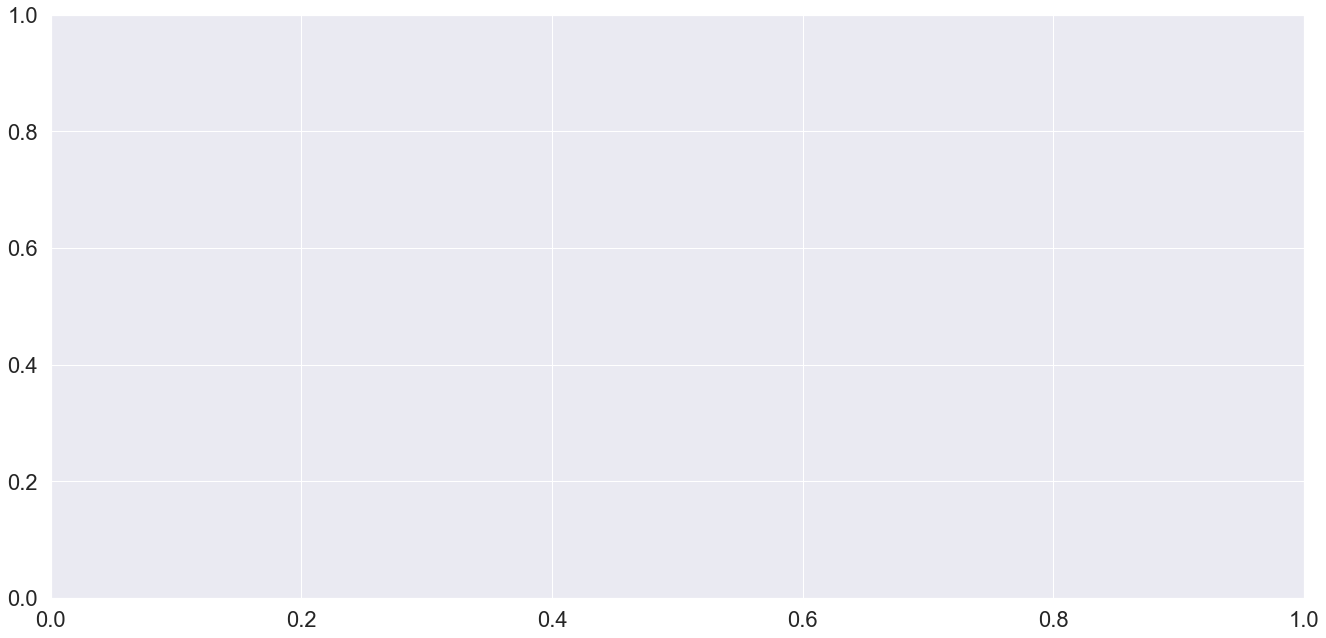

In [176]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

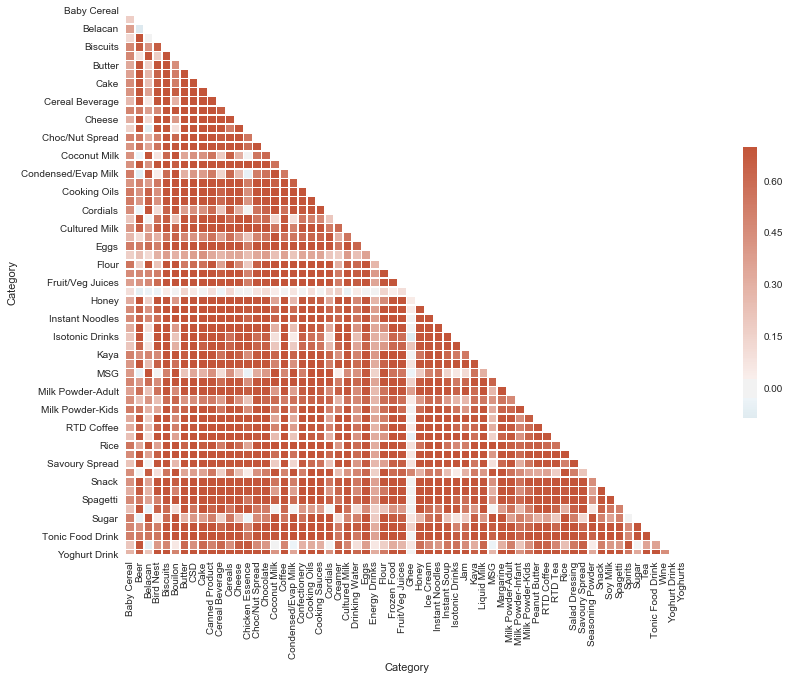

In [31]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr3, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr3, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

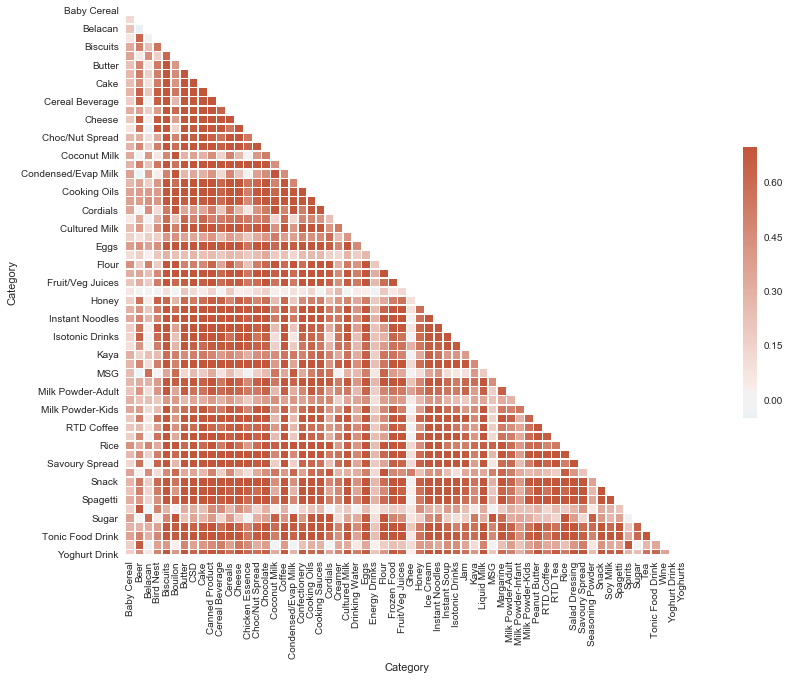

In [32]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr2, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
_ , p_value = calculate_bartlett_sphericity(df)
p_value

0.0

In [34]:
_ , p_value = calculate_bartlett_sphericity(df2)
p_value

0.0

In [35]:
_ , p_value = calculate_bartlett_sphericity(df3)
p_value

0.0

In [36]:
_, kmo_score = calculate_kmo(df)
kmo_score 

0.9252279123228717

In [37]:
_, kmo_score = calculate_kmo(df2)
kmo_score 

0.9741408869596114

In [38]:
_, kmo_score = calculate_kmo(df3)
kmo_score 

0.9519893413860994

In [39]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

def variance_explained(num_of_pcs,data):
    f = FactorAnalyzer(n_factors=num_of_pcs,method='principal', rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

In [40]:
# all the three share the same colname names
colnames = list(df.columns)
colnames

['Baby Cereal',
 'Beer',
 'Belacan',
 'Bird Nest',
 'Biscuits',
 'Bouilon',
 'Butter',
 'CSD',
 'Cake',
 'Canned Product',
 'Cereal Beverage',
 'Cereals',
 'Cheese',
 'Chicken Essence',
 'Choc/Nut Spread',
 'Chocolate',
 'Coconut Milk',
 'Coffee',
 'Condensed/Evap Milk',
 'Confectionery',
 'Cooking Oils',
 'Cooking Sauces',
 'Cordials',
 'Creamer',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Energy Drinks',
 'Flour',
 'Frozen Food',
 'Fruit/Veg Juices',
 'Ghee',
 'Honey',
 'Ice Cream',
 'Instant Noodles',
 'Instant Soup',
 'Isotonic Drinks',
 'Jam',
 'Kaya',
 'Liquid Milk',
 'MSG',
 'Margarine',
 'Milk Powder-Adult',
 'Milk Powder-Infant',
 'Milk Powder-Kids',
 'Peanut Butter',
 'RTD Coffee',
 'RTD Tea',
 'Rice',
 'Salad Dressing',
 'Savoury Spread',
 'Seasoning Powder',
 'Snack',
 'Soy Milk',
 'Spagetti',
 'Spirits',
 'Sugar',
 'Tea',
 'Tonic Food Drink',
 'Wine',
 'Yoghurt Drink',
 'Yoghurts']

In [41]:
pd.set_option('display.max_rows', None)
evaluate_pcs(6,df3[colnames])
# remove multiple layer of index
#evaluate_pcs(6,df3[colnames]).rename_axis(None, axis=1).reset_index()

,PC1,PC2,PC3,PC4,PC5,PC6
Category,,,,,,
Baby Cereal,,,,,,
Beer,0.900102,,,,,
Belacan,,0.872799,,,,
Bird Nest,0.8541,,,,,
Biscuits,0.763204,,,,,
Bouilon,,0.91139,,,,
Butter,0.895718,,,,,
CSD,0.791869,,,,,
Cake,0.799046,,,,,


In [35]:
evaluate_pcs(10,df2[colnames])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Category,,,,,,,,,,
Baby Cereal,,,,,,,,,,
Beer,,,0.723465,,,,,,,
Belacan,,,,,,,,,0.726269,
Bird Nest,,,,,,,,,,
Biscuits,0.852558,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...
Tea,,,,,,,,,,
Tonic Food Drink,,,,,,,,,,
Wine,,,0.816556,,,,,,,


Text(0, 0.5, 'Proportion of Variance Explained by PC')

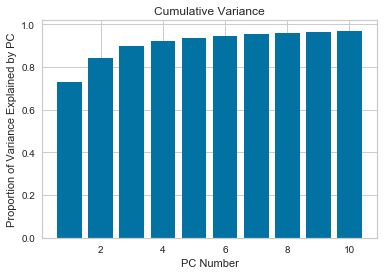

In [36]:
model1 = PCA(n_components=10)
model1.fit(df2[colnames])
PC1 = model1.components_ # Principal Components
explained_variance1 = model1.explained_variance_ #Explained Variance for each Principal Component
explained_variance_ratio1 = model1.explained_variance_ratio_  #Explained Variance Ratio for each Principal Component, sums to 1.
cum_var_ratio = np.cumsum(explained_variance_ratio1)
x = list(range(1,11))
plt.bar(x,cum_var_ratio)
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

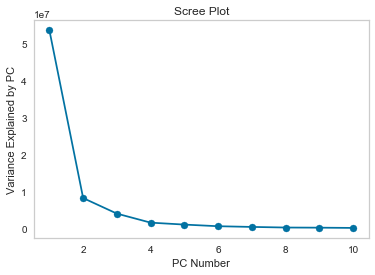

In [37]:
plt.scatter(range(1,len(explained_variance1)+1),explained_variance1)
plt.plot(range(1,len(explained_variance1)+1),explained_variance1)
plt.title('Screen Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()
plt.show()

In [38]:
kl = KneeLocator(range(1, len(explained_variance1)+1), explained_variance1, curve="convex", direction="decreasing")

kl.elbow

2

Text(0, 0.5, 'Proportion of Variance Explained by PC')

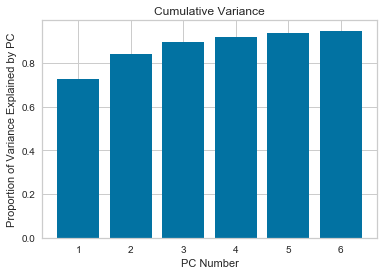

In [39]:
model1 = PCA(n_components=6)
model1.fit(df3[colnames])
PC1 = model1.components_ # Principal Components
explained_variance1 = model1.explained_variance_ #Explained Variance for each Principal Component
explained_variance_ratio1 = model1.explained_variance_ratio_  #Explained Variance Ratio for each Principal Component, sums to 1.
cum_var_ratio = np.cumsum(explained_variance_ratio1)
x = list(range(1,7))
plt.bar(x,cum_var_ratio)
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

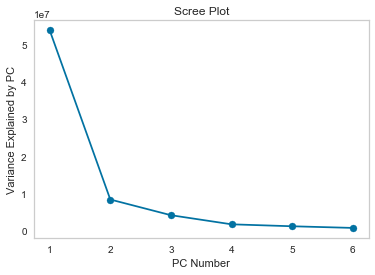

In [40]:
plt.scatter(range(1,len(explained_variance1)+1),explained_variance1)
plt.plot(range(1,len(explained_variance1)+1),explained_variance1)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()
plt.show()

In [41]:
kl = KneeLocator(range(1, len(explained_variance1)+1), explained_variance1, curve="convex", direction="decreasing")

kl.elbow

2

Text(0, 0.5, 'Proportion of Variance Explained by PC')

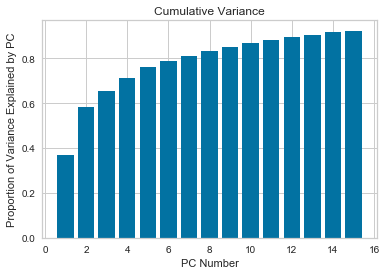

In [42]:
model1 = PCA(n_components=15)
model1.fit(df[colnames])
PC1 = model1.components_ # Principal Components
explained_variance1 = model1.explained_variance_ #Explained Variance for each Principal Component
explained_variance_ratio1 = model1.explained_variance_ratio_  #Explained Variance Ratio for each Principal Component, sums to 1.

cum_var_ratio = np.cumsum(explained_variance_ratio1)
x = list(range(1,16))
plt.bar(x,cum_var_ratio)
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

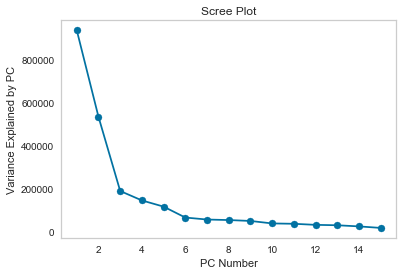

In [43]:
plt.scatter(range(1,len(explained_variance1)+1),explained_variance1)
plt.plot(range(1,len(explained_variance1)+1),explained_variance1)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()
plt.show()


In [44]:
kl = KneeLocator(range(1, len(explained_variance1)+1), explained_variance1, curve="convex", direction="decreasing")

kl.elbow

3

In [45]:
### try to drop a few columns. take df3 as an example
# select rows that are selected by the firsr 3 comp
try_ = evaluate_pcs(15,df2[colnames]).rename_axis(None, axis=1).reset_index()
a = try_[try_['PC1'] != ''].Category
b = try_[try_['PC2'] != ''].Category
c = try_[try_['PC3'] != ''].Category
keep = pd.concat([a,b,c]).values

In [46]:
new_dataset = df2[keep]

In [47]:
evaluate_pcs(3,new_dataset)

,PC1,PC2,PC3
Category,,,
Biscuits,0.849917,,
Butter,0.875157,,
CSD,0.787174,,
Cake,0.848029,,
Canned Product,0.75007,,
Cereal Beverage,0.799803,,
Cereals,0.754499,,
Cheese,0.897964,,
Chicken Essence,0.842573,,


In [48]:
variance_explained(3, new_dataset)

0.8063378135063337

In [49]:
# PCA on two components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(new_dataset)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

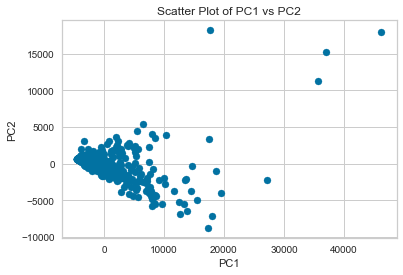

In [50]:
plt.scatter(principalDf.PC1,principalDf.PC2)
plt.title('Scatter Plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()